In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "\\datasets\\empire_psremoting_stager_2020-09-20170827.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

df.shape

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


(2744, 177)

In [39]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num, replace=True)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data

# split the training and testing sets manually, make sure that positive data is in the testing set
def train_test_split_m(X, y, positive_list, test_size=0.33):

    sample_len = int(len(X) * 0.33 - len(positive_list))
    
    X_test = X.iloc[positive_list]
    X = X.drop(positive_list)
    
    X_random = X.sample(sample_len)
    X = X.drop(X_random.index)
    X_test = pd.concat([X_test, X_random], axis=0, ignore_index=True)
    y_test = list([1 for i in range(len(positive_list))] + [0 for i in range(sample_len)])

    X_train = X
    y_train = [0 for i in range(len(X_train))]
    
    return (X_train, X_test, y_train, y_test)

In [3]:
features = ["Channel", "EventID", "Message", "DestPort", "LayerRTID", "ParentProcessName", "NewProcessName", "ParentImage", "Image", "DestinationPort", "User"]
df = df[features]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(2744, 11)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [4]:
from sdv.tabular import CTGAN

# model = CTGAN(cuda=True)
# model.fit(df)
# save and reuse the model
# model.save('RemotePwshExecution.pkl')

model = CTGAN.load(r'models\\RemotePwshExecution.pkl')

In [5]:
new_data = model.sample(num_rows=1000000)
new_data.head()

,Channel,EventID,Message,DestPort,LayerRTID,ParentProcessName,NewProcessName,ParentImage,Image,DestinationPort,User
0,Microsoft-Windows-Sysmon/Operational,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Microsoft-Windows-Sysmon/Operational,23,"Provider ""Variable"" is Started. \r\n\r\nDetail...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NT AUTHORITY\NETWORK SERVICE
2,Microsoft-Windows-Sysmon/Operational,10,The handle to an object was closed.\r\n\r\nSub...,NaN,NaN,NaN,NaN,NaN,C:\Windows\System32\whoami.exe,NaN,NT AUTHORITY\SYSTEM
3,Microsoft-Windows-Sysmon/Operational,12,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\svchost.exe,NaN,NaN
4,Windows PowerShell,4688,NaN,NaN,NaN,NaN,NaN,NaN,C:\Windows\System32\svchost.exe,NaN,NaN


In [ ]:
# # for debugging only
# count_items(preprocess_labelEncoder(df))
# Counter(new_data['DestPort']).items()

## Use hunter program on new data

In [8]:
# Analytic I
I = (
new_data[features]

[(new_data['Channel'].isin(['Microsoft-Windows-PowerShell/Operational','Windows PowerShell']))
    & (new_data['EventID'].isin(['400','4103']))
    & (new_data['Message'].str.contains('.*HostApplication.*wsmprovhost.*', regex=True))
]
)
I

,Channel,EventID,Message,DestPort,LayerRTID,ParentProcessName,NewProcessName,ParentImage,Image,DestinationPort,User
42,Microsoft-Windows-PowerShell/Operational,4103,Engine state is changed from None to Available...,NaN,NaN,NaN,NaN,NaN,C:\WindowsAzure\GuestAgent_2.7.41491.993_2020-...,NaN,NaN
2437,Windows PowerShell,4103,"Provider ""FileSystem"" is Started. \r\n\r\nDeta...",NaN,NaN,NaN,NaN,NaN,C:\Packages\Plugins\Microsoft.Azure.NetworkWat...,NaN,NaN
32883,Windows PowerShell,4103,"Provider ""Variable"" is Started. \r\n\r\nDetail...",NaN,40.0,NaN,NaN,NaN,NaN,NaN,NT AUTHORITY\NETWORK SERVICE
68214,Windows PowerShell,4103,"Provider ""FileSystem"" is Started. \r\n\r\nDeta...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91116,Windows PowerShell,4103,"Provider ""FileSystem"" is Started. \r\n\r\nDeta...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103326,Windows PowerShell,4103,"Provider ""Registry"" is Started. \r\n\r\nDetail...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104919,Windows PowerShell,4103,"Provider ""FileSystem"" is Started. \r\n\r\nDeta...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133226,Windows PowerShell,4103,"Provider ""Environment"" is Started. \r\n\r\nDet...",NaN,NaN,NaN,NaN,NaN,C:\windows\System32\WindowsPowerShell\v1.0\pow...,NaN,NaN
201374,Windows PowerShell,4103,"Provider ""FileSystem"" is Started. \r\n\r\nDeta...",NaN,NaN,NaN,NaN,C:\Windows\System32\wsmprovhost.exe,C:\Windows\System32\wbem\WmiPrvSE.exe,NaN,NaN
223346,Windows PowerShell,4103,"Provider ""Variable"" is Started. \r\n\r\nDetail...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Analytic II
II  = (
new_data[features]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == '5156')
    & (
        (new_data['DestPort'] == 5985)
        | (new_data['DestPort'] == 5986)
    )
#     & (new_data['LayerRTID'] == 44)
]
# [((new_data['DestPort'] == 5985)
#     | (new_data['DestPort'] == 5986)
#     | (new_data['DestPort'] == '3617.0'))
# ]
)
II

,Channel,EventID,Message,DestPort,LayerRTID,ParentProcessName,NewProcessName,ParentImage,Image,DestinationPort,User


In [11]:
# Analytic III
III = (
new_data[features]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == '4688')
    & (
        (new_data['ParentProcessName'].str.lower().str.endswith('wsmprovhost.exe', na=False))
        | (new_data['NewProcessName'].str.lower().str.endswith('wsmprovhost.exe', na=False))
    )
]
)
III

,Channel,EventID,Message,DestPort,LayerRTID,ParentProcessName,NewProcessName,ParentImage,Image,DestinationPort,User
92,Security,4688,The Windows Filtering Platform has permitted a...,NaN,37.0,C:\Windows\System32\wsmprovhost.exe,C:\Windows\System32\conhost.exe,NaN,NaN,NaN,NaN
126,security,4688,A handle to an object was requested.\r\n\r\nSu...,NaN,40.0,NaN,C:\Windows\System32\wsmprovhost.exe,NaN,C:\windows\system32\svchost.exe,NaN,NaN
829,security,4688,"Provider ""Environment"" is Started. \r\n\r\nDet...",NaN,40.0,C:\Windows\System32\wsmprovhost.exe,NaN,NaN,NaN,NaN,NaN
1084,security,4688,The Windows Filtering Platform has permitted a...,NaN,40.0,C:\Windows\System32\wsmprovhost.exe,NaN,NaN,NaN,NaN,NaN
1585,security,4688,NaN,NaN,NaN,C:\Windows\System32\svchost.exe,C:\Windows\System32\wsmprovhost.exe,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
997807,security,4688,An attempt was made to duplicate a handle to a...,NaN,NaN,C:\Windows\System32\wsmprovhost.exe,NaN,NaN,NaN,NaN,NaN
998005,security,4688,The Windows Filtering Platform has permitted a...,NaN,NaN,C:\Windows\System32\wsmprovhost.exe,NaN,NaN,NaN,NaN,NaN
999412,security,4688,Pipeline execution details for command line: ...,NaN,NaN,C:\Windows\System32\wsmprovhost.exe,C:\Windows\System32\conhost.exe,NaN,C:\Packages\Plugins\Microsoft.Azure.NetworkWat...,NaN,NaN
999475,security,4688,The handle to an object was closed.\r\n\r\nSub...,NaN,40.0,NaN,C:\Windows\System32\wsmprovhost.exe,NaN,NaN,NaN,NaN


In [12]:
# Analytic IV
IV = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '1')
    & (
        (new_data['ParentImage'].str.lower().str.endswith('wsmprovhost.exe', na=False))
        | (new_data['Image'].str.lower().str.endswith('wsmprovhost.exe', na=False))
    )
]
)
IV

,Channel,EventID,Message,DestPort,LayerRTID,ParentProcessName,NewProcessName,ParentImage,Image,DestinationPort,User
1040,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,3626.0,NaN
1360,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN,NaN
2306,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN,NaN
3498,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN,NaN
3627,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN,THESHIRE\pgustavo
...,...,...,...,...,...,...,...,...,...,...,...
993058,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\Windows\System32\wsmprovhost.exe,NaN,NaN
994143,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN,NaN
998584,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\Windows\System32\wsmprovhost.exe,NaN,NaN
998600,Microsoft-Windows-Sysmon/Operational,1,NaN,NaN,NaN,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN,NaN


In [13]:
# Analytic V
V = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '3')
    & (
        (new_data['DestinationPort'] == 5985)
        | (new_data['DestinationPort'] == 5986)
    )
    & (~new_data['User'].isin(['NT AUTHORITY\\NETWORK SERVICE', 'NT AUTHORITY\\SYSTEM']))
]
)
V

,Channel,EventID,Message,DestPort,LayerRTID,ParentProcessName,NewProcessName,ParentImage,Image,DestinationPort,User


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [16]:
# randomly pick from results of analytics
results = [I, III, IV] # II, V
# not pick from II because original data doesn't have result from it
pick_nums = [350, 350, 350] # 6000
gen_data = random_generator(results, pick_nums)

gen_data.shape

(1050, 11)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 0.70


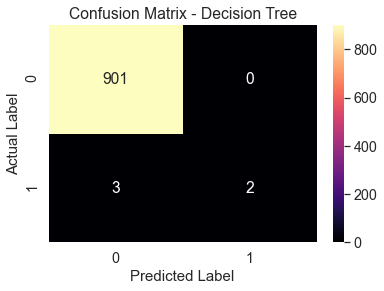

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       901
           1       1.00      0.40      0.57         5

    accuracy                           1.00       906
   macro avg       1.00      0.70      0.78       906
weighted avg       1.00      1.00      1.00       906



In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess(df)
X, le_dict = labelEncoder_get(X)
y = labelList(df.shape[0], [678, 478, 745, 856, 535, 867, 689, 1415, 1418])

clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

In [37]:
# X = preprocess(df)
# X, le_dict = labelEncoder_get(X)
# X_gen = preprocess(gen_data)
# X_gen = labelEncoder_trans(X_gen, le_dict)
# Counter(gen_data['LayerRTID']).items()
for i in range(len(gen_data)):
    gen_data['LayerRTID'] = np.nan
    gen_data['DestinationPort'] = np.nan

### Original data with generated data
Generated data should only be added into trianing set.

Channel
EventID
Message
DestPort
LayerRTID
ParentProcessName
NewProcessName
ParentImage
Image
DestinationPort
User
Balanced accuracy score: 0.90


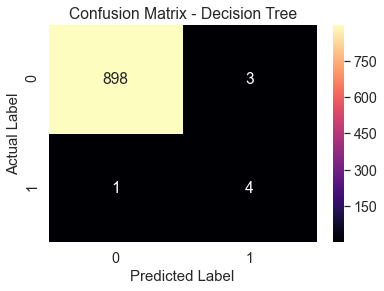

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       901
           1       0.57      0.80      0.67         5

    accuracy                           1.00       906
   macro avg       0.79      0.90      0.83       906
weighted avg       1.00      1.00      1.00       906



In [38]:
X_gen = preprocess(gen_data)
X_gen = labelEncoder_trans(X_gen, le_dict)
# add generated data to the original training set
X_train_new = pd.concat([X_train, X_gen], axis=0)

# generated data are all positive
for i in range(len(gen_data)):
    y_train.append(1)

clf.fit(X_train_new, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

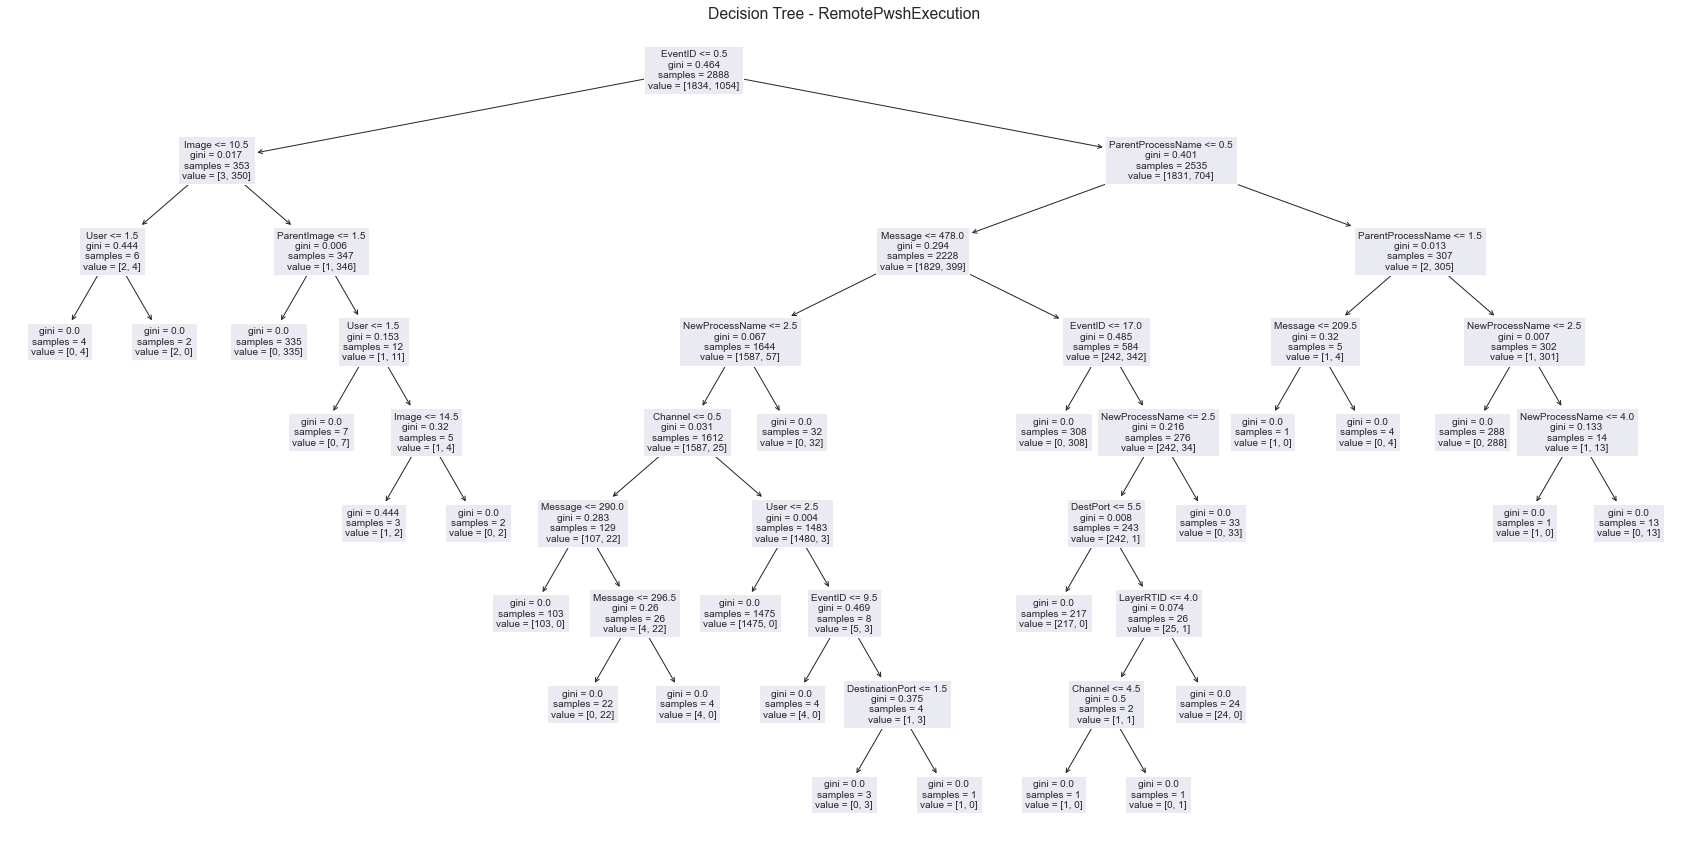

In [41]:
# draw the tree
from sklearn import tree

plt.figure(figsize=(30, 15))
tree.plot_tree(clf, feature_names=features, fontsize=10)
plt.title("Decision Tree - RemotePwshExecution")
plt.savefig(r'DecisionTree\RemotePwshExecution.png', dpi=100, transparent=True)

## Save generated data

In [43]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(os.getcwd() + r'\generated_datasets\empire_psremoting_stager_new1.json', orient='records')

# dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\empire_dllinjection_LoadLibrary_CreateRemoteThread_new.json")
# dataset.head()